In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import collections
from utilities import get_network

df = pd.read_csv('./data/dataset-with-toxicity.csv')

(0.0, 15.0)

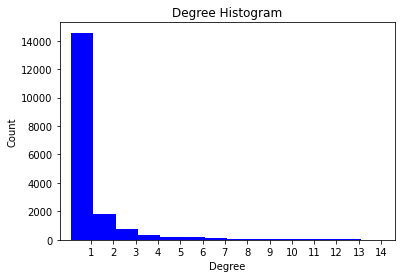

In [21]:
G = get_network(df)

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, color="b", width=1.0)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

ax.set_xlim(0, 15)

Text(0.5, 0, 'rank')

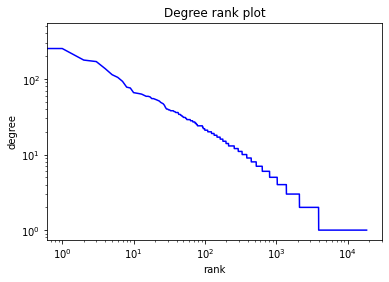

In [12]:
G = get_network(df)

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)

plt.loglog(degree_sequence, "b-")
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
